In [10]:

# Import the relevant modules
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Import CNTK
import cntk as C


import cntk.io.transforms as xforms
import cntk.tests.test_utils
#C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
    
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import shutil
import struct
import sys
    
import glob
import socket
%matplotlib inline


In [21]:
if socket.gethostname() == 'dsvm':
    root = r'/home/kumaran/Data'
else:
    root = r'E:\Temp'
    
data_dir = os.path.join(root, 'lfw')
data_dir = os.path.join(root, 'MNIST')
# down data from http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
# model dimensions
img_h = 28
img_w  = 28
input_dim = img_h * img_w
num_channels = 3
num_classes  = 0
latent_dim = 15

e_kernel_1 = (5,5)
e_stride_1 = (2,2)
e_filter_1 = 1
e_filter_2 =  128

isFast = False
epoch_size = 30000        # 30000 samples is half the dataset size
minibatch_size = 128
num_sweeps_to_train_with = 10 if isFast else 1000
num_samples_per_sweep = 60000
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) // minibatch_size
num_samples_to_test = 10000

#map_file = os.path.join(data_dir, 'cntk_image_data.tsv')

In [22]:
# prepare CNTK imageReader data
'''
with open(map_file, 'w') as out:
    for f in glob.glob(data_dir + '\\*\\*.jpg'):
        out.write('{}\t0\n'.format(f))
'''
def plot_image(img1, img2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))

    axes[0].imshow(img1, cmap="gray")
    axes[0].axis("off")
    
    axes[1].imshow(img2, cmap="gray")    
    axes[1].axis("off")


In [23]:
def create_reader_mnist(path, is_training):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels = C.io.StreamDef(field='labels', shape=10, is_sparse=False),
        input   = C.io.StreamDef(field='features', shape=784, is_sparse=False)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

def create_reader_lfw(map_file, train, is_training):
    print("Reading map file:", map_file)    

    if not os.path.exists(map_file):
        raise RuntimeError("This tutorials depends 201A tutorials, please run 201A first.")

    # transformation pipeline for the features has jitter/crop only when training
    transforms = []
    # train uses data augmentation (translation only)
    if train and False:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.8)
        ]
    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear')        
    ]
    # deserializer
    return c.io.MinibatchSource(c.io.ImageDeserializer(map_file, c.io.StreamDefs(
        input = c.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = c.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [33]:
def encoder_cnn(input):    
    with C.layers.default_options(init=C.normal(scale=0.02)):

        dfc_dim = 1024
        df_dim = 64

        print('Discriminator convolution input shape', input.shape)
        x = C.reshape(input, (1, img_h, img_w))

        #h0 = C.layers.Convolution2D(e_kernel_1, e_filter_1, strides=e_stride_1, pad=True, activation=C.relu)(x)        
        #print('h0 shape :', h0.shape)
                
        h1 = C.layers.Convolution2D(e_kernel_1, e_filter_2, strides=e_stride_1, pad=True, activation=C.relu)(x)        
        print('h1 shape :', h1.shape)
        
        
        mu = C.layers.Dense(latent_dim, activation=None)(h1)        
        print('mu shape :', mu.shape)
        
        sig = C.layers.Dense(latent_dim, activation=C.relu, init=C.normal(scale=1))(h1)
        print('sig shape :', sig.shape)

        return mu, sig
    
def decoder_cnn(z):
    with C.layers.default_options(init=C.normal(scale=0.02)):
        
        
        print('Generator input shape: ', z.shape)
        s_h2, s_w2 = img_h//2, img_w//2 #Input shape (14,14)
        s_h4, s_w4 = img_h//4, img_w//4 # Input shape (7,7)
        gfc_dim = 1024
        gf_dim = 64
        
        h1 = C.layers.Dense([e_filter_2, s_h2,  s_w2], activation=C.relu)(z)        
        print('h1 shape', h1.shape)
        
        '''
        h2 = C.layers.ConvolutionTranspose2D(e_kernel_1,
                                  num_filters=e_filter_1,
                                  strides=e_stride_1,
                                  pad=True,
                                  output_shape=(s_h2, s_w2), activation=C.relu)(h1)        
        print('h2 shape', h2.shape)
        '''

        h3 = C.layers.ConvolutionTranspose2D(e_kernel_1,
                                  num_filters=e_filter_1,
                                  strides=e_stride_1,
                                  pad=True,
                                  output_shape=(img_h, img_w),
                                  activation=C.sigmoid)(h1)
        print('h3 shape :', h3.shape)

        return C.reshape(h3, img_h * img_w)

def decoder(input):
    return decoder_cnn(input)
    intermediate = C.layers.Sequential([C.layers.Dense(200, activation = C.relu),
                                        C.layers.Dense(200, activation = C.relu),
                               C.layers.Dense(input_dim, activation=C.sigmoid)])(input)
    return intermediate
    
def encoder(input):
    return encoder_cnn(input)
    intermediate = C.layers.Sequential([C.layers.Dense(200, activation = C.relu),
                                        C.layers.Dense(200, activation = C.relu),
                               C.layers.Dense(latent_dim, activation=C.relu)])(input)
    
    mu = C.layers.Dense(latent_dim, activation=None)(intermediate)
    sigma = C.layers.Dense(latent_dim, activation=C.relu)(intermediate)

    
    return mu, sigma
network = {}


def create_network():
    input = C.input_variable(input_dim)
    label = C.input_variable(input_dim)
    network['input'] = input
    network['label'] = label

    # Create the model function
    mu, sig = encoder(input/255.0)
    
    
    z = C.random.normal_like(mu, mean=0, scale=1)
    z = mu + z * sig
    network['mu'] = mu
    network['sig'] = sig
    
    z_placeholder = C.placeholder()            
    output = C.as_block(decoder(z_placeholder), [(z_placeholder, z)], 'Decoder', 'Decoder_1')    
    network['output'] = output
    target = input/255.0
    construction_loss = C.losses.squared_error(target, output)
    
    
    l1 = C.element_times(target, C.log(output))
    l2 = C.element_times(1.0-target, C.log(1.0-output))
    print(l1.shape)
    print(l2.shape)
                         
    #construction_loss = C.reduce_sum(-1 * C.plus(l1, l2))
    #print(construction_loss.shape)
    construction_loss = C.reduce_sum(C.binary_cross_entropy(output, target))                                 
    
    log_stddev = C.log(sig)
    kl_loss = - 0.5 * C.reduce_sum((1 + C.log(C.square(sig)) - C.square(mu) - C.square(C.exp(log_stddev))))
    loss = 0.5 * construction_loss + 0.5 * kl_loss
    
    error  = C.classification_error(output, target)
    network['loss'] = loss
    network['error'] = error
    return network



In [34]:
def train(train_file, test_file):
    create_network()
    
    loss = network['loss']
    output = network['output']
    error = network['error']
    input = network['input']
    label = network['label']
    
     # Instantiate the trainer object to drive the model training
    lr_per_sample = [0.00003]
    lr_schedule = C.learning_parameter_schedule_per_sample(lr_per_sample, epoch_size)
    # Momentum which is applied on every minibatch_size = 64 samples
    momentum_schedule = C.momentum_schedule(0.9126265014311797, minibatch_size)
    # We use a variant of the Adam optimizer which is known to work well on this dataset
    # Feel free to try other optimizers from
    # https://www.cntk.ai/pythondocs/cntk.learner.html#module-cntk.learner
    learner = C.fsadagrad(output.parameters,
                         lr=lr_schedule, momentum=momentum_schedule)
    
    #learner = C.adam(output.parameters, lr=lr_schedule, momentum=momentum_schedule)

    # Instantiate the trainer
    progress_printer = C.logging.ProgressPrinter(0)
    trainer = C.Trainer(output, (loss, error), learner, progress_printer)

    # Map the data streams to the input and labels.
    # Note: for autoencoders input == label
    input_map = {
        input  : train_file.streams.input,
        label  : train_file.streams.labels
    }
    
    test_input_map = {
        input  : test_file.streams.input,
        label  : test_file.streams.labels
    }
    aggregate_metric = 0
    for i in range(num_minibatches_to_train):
        # Read a mini batch from the training data file
        data = train_file.next_minibatch(minibatch_size, input_map = input_map)

        # Run the trainer on and perform model training
        trainer.train_minibatch(data)
        samples = trainer.previous_minibatch_sample_count
        aggregate_metric += trainer.previous_minibatch_evaluation_average * samples

    train_error = (aggregate_metric*100.0) / (trainer.total_number_of_samples_seen)
    print("Average training error: {0:0.2f}%".format(train_error))
    
    metric_numer = 0.0
    metric_denom = 0
    while True:        
        data = test_file.next_minibatch(minibatch_size,
                                       input_map = test_input_map)
        n = minibatch_size
        eval_error = trainer.test_minibatch(data)
        metric_numer += np.abs(eval_error * n)
        metric_denom += n
        if metric_denom > num_samples_to_test:
            break
    # Average of evaluation errors of all test minibatches
    test_error = (metric_numer*100.0) / (metric_denom)
    print("Average test error: {0:0.2f}%".format(test_error))

    
    

train_file = create_reader_mnist(os.path.join(data_dir, 'Train-28x28_cntk_text.txt'), True)
test_file = create_reader_mnist(os.path.join(data_dir, 'Test-28x28_cntk_text.txt'), True)

train(train_file, test_file)

Discriminator convolution input shape (784,)
h1 shape : (128, 14, 14)
mu shape : (15,)
sig shape : (15,)
Generator input shape:  (-2,)
h1 shape (-2,)
h3 shape : (-2,)
(784,)
(784,)
 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------


/anaconda/envs/py35/lib/python3.5/site-packages/cntk/learners/__init__.py:340: RuntimeWarning: When providing the schedule as a number, epoch_size is ignored
  warnings.warn('When providing the schedule as a number, epoch_size is ignored', RuntimeWarning)


Learning rate per 1 samples: 3e-05
      436        436      0.902      0.902           128
      434        433      0.901        0.9           384
      431        428       0.88      0.864           896
      427        423      0.875      0.871          1920
      411        397      0.915      0.952          3968
      362        315      0.918      0.922          8064
      298        236      0.678      0.441         16256
      257        217      0.551      0.425         32640
      222        187       0.47       0.39         65408
      186        151      0.388      0.306        130944
      155        123      0.307      0.226        262016
      130        105      0.247      0.187        524160
      108       86.9      0.205      0.163       1048448
     92.1       75.7      0.161      0.116       2097024
       80       67.9      0.122     0.0827       4194176
     71.4       62.8     0.0927     0.0637       8388480
     63.7         56     0.0671     0.0415      16777

In [94]:
test = create_reader_mnist(os.path.join(data_dir, 'Test-28x28_cntk_text.txt'), False)
input_map = {
        network['input']  : test.streams.input,
        network['label']  : test.streams.labels
    }
data = test.next_minibatch(minibatch_size, input_map=input_map)
output = network['output'].eval(data)

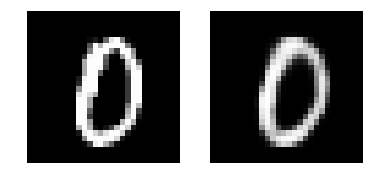

In [98]:
np.random.seed()
idx = np.random.choice(minibatch_size)
in_img = data[network['input']].data.asarray()[idx,:,:].reshape(img_h, img_w)
out_img = output[idx,:].reshape(img_h, img_w)
plot_image(in_img, out_img)

In [99]:
d = network['output'].find_by_name('Decoder_1')


x = d.clone('freeze', {d.arguments[0] : C.input_variable(latent_dim)})

array([[-5.90804592e-03, -1.10823974e-01, -1.69394829e-03,
        -8.10657628e-03,  9.41572607e-01, -7.62432635e-01,
        -7.29749978e-01,  1.41884945e-02,  1.88793170e+00,
        -2.46265833e-03, -8.83262791e-03,  4.95558381e-01,
        -1.71442103e+00, -6.23207353e-03,  7.17319641e-03]], dtype=float32)

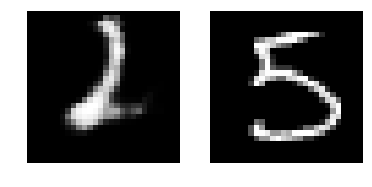

In [144]:
np.random.seed()
idx = np.random.choice(minibatch_size)
C.cntk_py.set_fixed_random_seed(idx)
random = C.random.normal((latent_dim), mean=0, scale=1)
plot_image(x.eval(random.eval()).reshape(img_h, img_w) , data[network['input']].data.asarray()[idx,:,:].reshape(img_h, img_w)) 

network['mu'].eval(data[network['input']].data.asarray()[idx,:,:])


In [208]:

x.eval(C.random.normal((32), mean=0, scale=1).eval()).shape

(1, 784)